In [4]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.2 MB/s eta 0:00:00


# **Library Import**

In [5]:
import tensorflow_datasets as tfds
import torch
from torch_geometric.data import Data
from torch_geometric.data import Batch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, GINConv, Sequential, global_mean_pool
from torch.nn import Linear, CrossEntropyLoss
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# **Visualize Data**

In [6]:
import torch
import networkx as nx
from torch_geometric.utils import to_networkx

In [7]:
import numpy as np
import tensorflow_datasets as tfds
import torch
from torch_geometric.data import Data

def load_single_graph():
    ds, _ = tfds.load('cardiotox', split='train', with_info=True, as_supervised=False)
    for example in tfds.as_numpy(ds.take(1)):  # Taking just one sample for visualization
        node_features = torch.tensor(example['atoms'], dtype=torch.float)
        # Convert the indices to a numpy array and reshape it correctly
        edge_indices_np = np.array(example['pair_mask'].nonzero())
        if edge_indices_np.shape[0] != 2:
            edge_indices_np = edge_indices_np.reshape(2, -1)  # Ensuring it's 2 rows
        edge_index = torch.tensor(edge_indices_np, dtype=torch.long)
        data = Data(x=node_features, edge_index=edge_index)
        return data


In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def plot_graph(data):
    # Check the shape of edge_index to confirm it's correct
    if data.edge_index.size(0) != 2:
        raise ValueError("Edge index must have a size of 2 in the first dimension.")

    # Convert to a networkx graph
    G = to_networkx(data, to_undirected=True)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, node_size=700, node_color="skyblue", with_labels=True, font_weight='bold')
    plt.title("Graph Visualization")
    plt.show()


Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6523 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cardiotox/1.0.0.incompleteBU70P9/cardiotox-train.tfrecord*...:   0%|      …

Generating validation examples...:   0%|          | 0/1631 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cardiotox/1.0.0.incompleteBU70P9/cardiotox-validation.tfrecord*...:   0%| …

Generating test examples...:   0%|          | 0/839 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cardiotox/1.0.0.incompleteBU70P9/cardiotox-test.tfrecord*...:   0%|       …

Generating test2 examples...:   0%|          | 0/177 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cardiotox/1.0.0.incompleteBU70P9/cardiotox-test2.tfrecord*...:   0%|      …

Dataset cardiotox downloaded and prepared to /root/tensorflow_datasets/cardiotox/1.0.0. Subsequent calls will reuse this data.


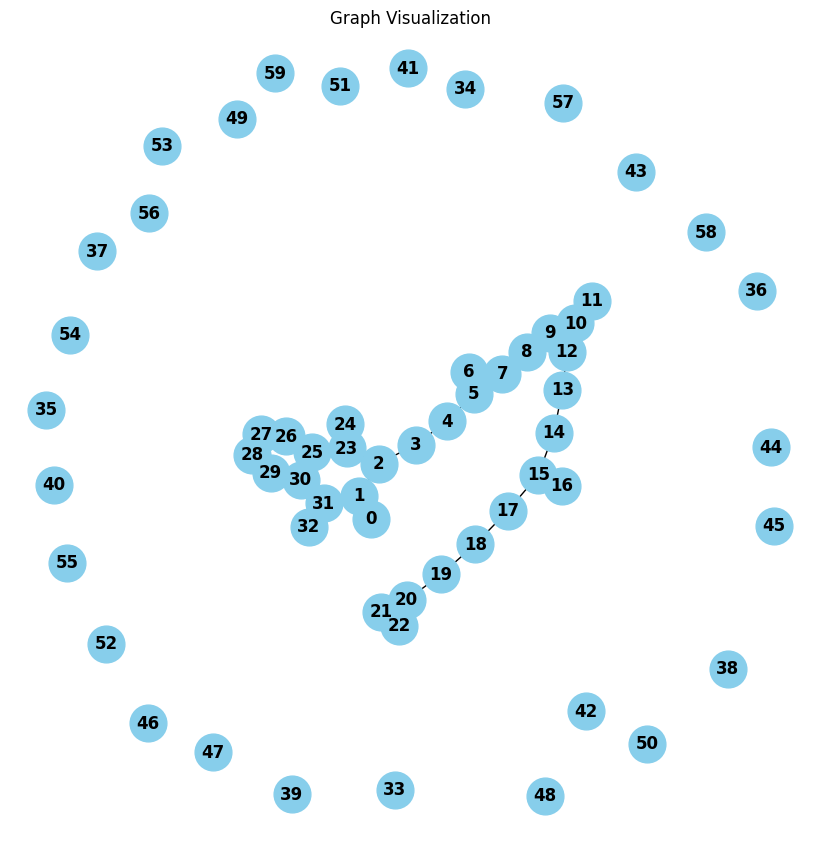

In [9]:
# Load a single graph from the dataset
single_graph = load_single_graph()

# Plot the graph
plot_graph(single_graph)


# **Load Data**

In [10]:
def load_data(split):
    # Placeholder for data loading logic, replace 'cardiotox' with your dataset
    ds, ds_info = tfds.load('cardiotox', split=split, with_info=True, as_supervised=False)
    graph_data_list = []
    for example in tfds.as_numpy(ds):
        node_features = torch.tensor(example['atoms'], dtype=torch.float)
        edge_index = torch.nonzero(torch.tensor(example['pair_mask']), as_tuple=False).t().contiguous()
        edge_attr = torch.tensor(example['pairs'][edge_index[0], edge_index[1]], dtype=torch.float)
        label = torch.tensor(example['active'], dtype=torch.long)
        data = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr, y=label[1])
        graph_data_list.append(data)
    return DataLoader(graph_data_list, batch_size=32, shuffle=True)
train_data = load_data('train')
val_data = load_data('validation')  # Adjust the split name as per available in the dataset
test_data = load_data('test')

# **Graph Convolutional Network**

In [11]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(27, 16)  # First GCN layer
        self.conv2 = GCNConv(16, 32)  # Second GCN layer
        self.fc = torch.nn.Linear(32, 2)  # Fully connected layer for classification

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))  # Apply first GCN layer
        x = F.relu(self.conv2(x, edge_index))  # Apply second GCN layer

        x = global_mean_pool(x, batch)  # Pool node features to get graph-level representation
        x = self.fc(x)  # Apply final fully connected layer

        return F.log_softmax(x, dim=1)

model = GNN()


In [12]:
# Define the optimizer and the criterion for training
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(train_data):
    model.train()
    total_loss = 0
    for data in train_data:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)  # Ensure data.y is the correct graph-level label
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_data)

def test(test_data):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()  # Ensure data.y is the correct graph-level label
            total += len(data.y)
    return correct / total

# Example usage

loss = train(train_data)
print(f'Average Training Loss: {loss:.4f}')
accuracy = test(test_data)
print(f'Accuracy: {accuracy * 100:.2f}%')


Average Training Loss: 0.4938
Accuracy: 76.52%


# **Graph Attention Network**

In [13]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels=27, out_channels=8, heads=8, concat=True)  # First GAT layer
        # For multi-head attention, out_channels per head * number of heads should be the next layer's in_channels
        self.conv2 = GATConv(in_channels=8*8, out_channels=32, heads=1, concat=True)  # Second GAT layer
        self.fc = torch.nn.Linear(32, 2)  # Fully connected layer for classification

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.elu(self.conv1(x, edge_index))  # Apply first GAT layer
        x = F.elu(self.conv2(x, edge_index))  # Apply second GAT layer

        x = global_mean_pool(x, batch)  # Pool node features to get graph-level representation
        x = self.fc(x)  # Apply final fully connected layer

        return F.log_softmax(x, dim=1)


In [14]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total


In [15]:
model = GAT()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

# Train and evaluate
loss = train(model, train_data, optimizer, criterion)
print(f'Average Training Loss: {loss:.4f}')
accuracy = test(model, test_data)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Average Training Loss: 0.4586
Test Accuracy: 69.73%


# **GraphSAGE**

In [16]:
class GraphSAGE(torch.nn.Module):
    def __init__(self):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels=27, out_channels=32, aggr='mean')  # First GraphSAGE layer
        self.conv2 = SAGEConv(in_channels=32, out_channels=64, aggr='mean')  # Second GraphSAGE layer
        self.fc = torch.nn.Linear(64, 2)  # Fully connected layer for classification

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)  # Aggregate node features to graph-level
        x = self.fc(x)
        return F.log_softmax(x, dim=1)


In [17]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total


In [18]:
model = GraphSAGE()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()


# Train and evaluate the model
loss = train(model, train_data, optimizer, criterion)
print(f'Average Training Loss: {loss:.4f}')
accuracy = test(model, test_data)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Average Training Loss: 0.4773
Test Accuracy: 74.73%


# **Graph Isomorphic Network**

In [19]:
class GIN(torch.nn.Module):
    def __init__(self):
        super(GIN, self).__init__()
        # Define MLP for GINConv
        nn1 = Sequential('x', [
            (Linear(27, 64), 'x -> x'),
            (torch.nn.ReLU(), 'x -> x'),
            (Linear(64, 64), 'x -> x')
        ])
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(64)

        nn2 = Sequential('x', [
            (Linear(64, 64), 'x -> x'),
            (torch.nn.ReLU(), 'x -> x'),
            (Linear(64, 64), 'x -> x')
        ])
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(64)

        self.fc1 = Linear(64, 64)
        self.fc2 = Linear(64, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)

        x = global_mean_pool(x, batch)  # Aggregate node features to graph-level
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)


In [20]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def test(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    return correct / total


In [21]:
model = GIN()
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()


# Train and evaluate the model
loss = train(model, train_data, optimizer, criterion)
print(f'Average Training Loss: {loss:.4f}')
accuracy = test(model, test_data)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Average Training Loss: 0.4240
Test Accuracy: 93.56%


# **Training and validation**

In [22]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    total_loss = 0
    for data in data_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def test(model, criterion, data_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for data in data_loader:
            out = model(data)
            loss = criterion(out, data.y)
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.y.size(0)
    accuracy = correct / total
    avg_loss = total_loss / len(data_loader)
    return accuracy, avg_loss

# Process a specific model
def process_model(model_class):
    model = model_class()
    optimizer = Adam(model.parameters(), lr=0.01)
    criterion = CrossEntropyLoss()

    train_loader = load_data('train')
    test_loader = load_data('test')
    val_loader = load_data('validation')

    train_losses = []
    test_losses = []
    test_accuracies = []
    val_accuracies = []


    for epoch in range(50):
        train_loss = train(model, optimizer, criterion, train_loader)
        test_accuracy, test_loss = test(model, criterion, test_loader)
        val_accuracy, _ = test(model, criterion, val_loader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        val_accuracies.append(val_accuracy)


        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Test Loss {test_loss:.4f}, Test Accuracy {test_accuracy:.4f}, Val Accuracy {val_accuracy:.4f}")

    # Plotting results
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(range(1, 51), train_losses, label='Train Loss')
    plt.plot(range(1, 51), test_losses, label='Test Loss')
    plt.title('Training and Testing Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(1, 51), test_accuracies, label='Test Accuracy')
    plt.plot(range(1, 51), val_accuracies, label='Validation Accuracy')
    plt.title('Testing and Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1: Train Loss 0.4801, Test Loss 0.5619, Test Accuracy 0.6973, Val Accuracy 0.7793
Epoch 2: Train Loss 0.4146, Test Loss 0.4735, Test Accuracy 0.7831, Val Accuracy 0.8001
Epoch 3: Train Loss 0.4060, Test Loss 0.4221, Test Accuracy 0.8093, Val Accuracy 0.7940
Epoch 4: Train Loss 0.3945, Test Loss 0.4026, Test Accuracy 0.8236, Val Accuracy 0.7940
Epoch 5: Train Loss 0.3928, Test Loss 0.4540, Test Accuracy 0.7843, Val Accuracy 0.8032
Epoch 6: Train Loss 0.3868, Test Loss 0.5069, Test Accuracy 0.7509, Val Accuracy 0.8044
Epoch 7: Train Loss 0.3838, Test Loss 0.4920, Test Accuracy 0.7664, Val Accuracy 0.8056
Epoch 8: Train Loss 0.3786, Test Loss 0.5806, Test Accuracy 0.7139, Val Accuracy 0.8087
Epoch 9: Train Loss 0.3769, Test Loss 0.3803, Test Accuracy 0.8308, Val Accuracy 0.8026
Epoch 10: Train Loss 0.3729, Test Loss 0.4362, Test Accuracy 0.7914, Val Accuracy 0.8136
Epoch 11: Train Loss 0.3723, Test Loss 0.4913, Test Accuracy 0.7604, Val Accuracy 0.8130
Epoch 12: Train Loss 0.3720, T

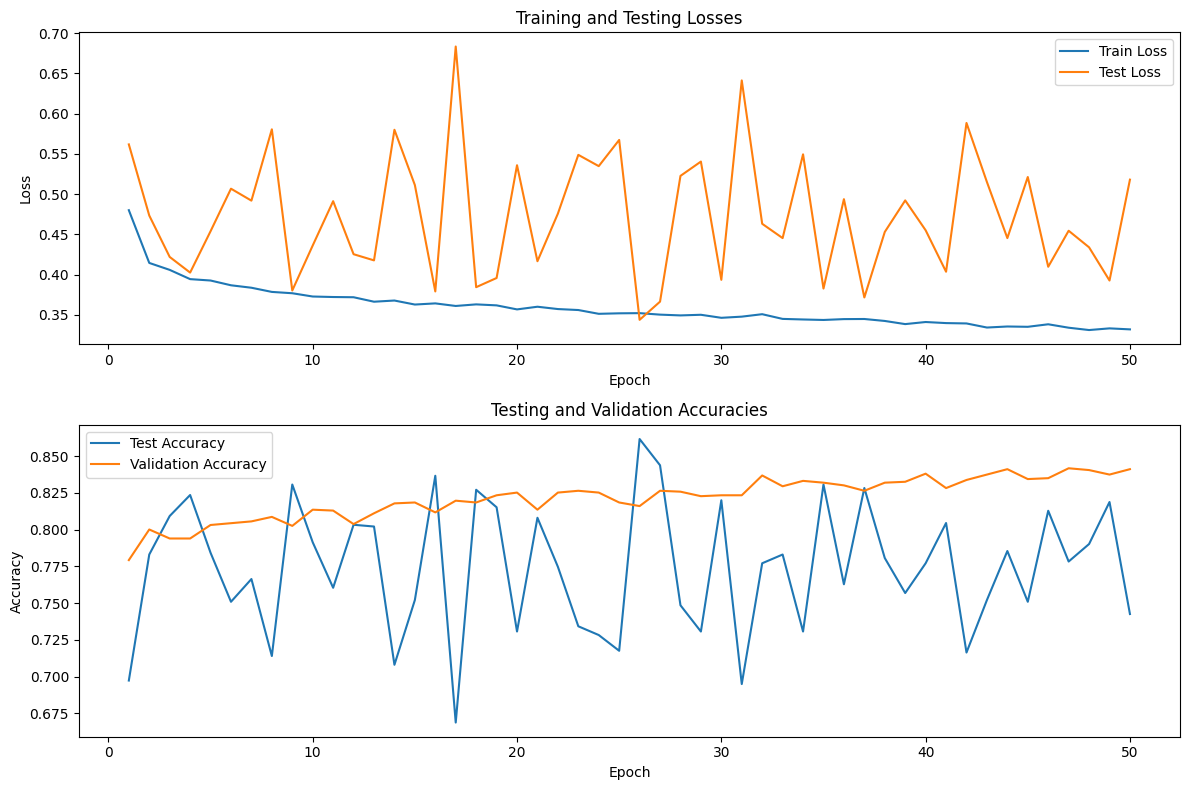

In [23]:
#process_model(GNN, 27, 2)
process_model(GNN)

Epoch 1: Train Loss 0.4584, Test Loss 0.6152, Test Accuracy 0.6734, Val Accuracy 0.7891
Epoch 2: Train Loss 0.4188, Test Loss 0.3770, Test Accuracy 0.8391, Val Accuracy 0.7946
Epoch 3: Train Loss 0.4034, Test Loss 0.4946, Test Accuracy 0.7700, Val Accuracy 0.7983
Epoch 4: Train Loss 0.3963, Test Loss 0.4893, Test Accuracy 0.7712, Val Accuracy 0.8130
Epoch 5: Train Loss 0.3869, Test Loss 0.3860, Test Accuracy 0.8319, Val Accuracy 0.7989
Epoch 6: Train Loss 0.3868, Test Loss 0.6093, Test Accuracy 0.7044, Val Accuracy 0.8093
Epoch 7: Train Loss 0.3756, Test Loss 0.3696, Test Accuracy 0.8415, Val Accuracy 0.8124
Epoch 8: Train Loss 0.3736, Test Loss 0.3910, Test Accuracy 0.8200, Val Accuracy 0.8142
Epoch 9: Train Loss 0.3701, Test Loss 0.5633, Test Accuracy 0.7032, Val Accuracy 0.8161
Epoch 10: Train Loss 0.3641, Test Loss 0.5389, Test Accuracy 0.7557, Val Accuracy 0.8142
Epoch 11: Train Loss 0.3617, Test Loss 0.4815, Test Accuracy 0.7938, Val Accuracy 0.8130
Epoch 12: Train Loss 0.3608, T

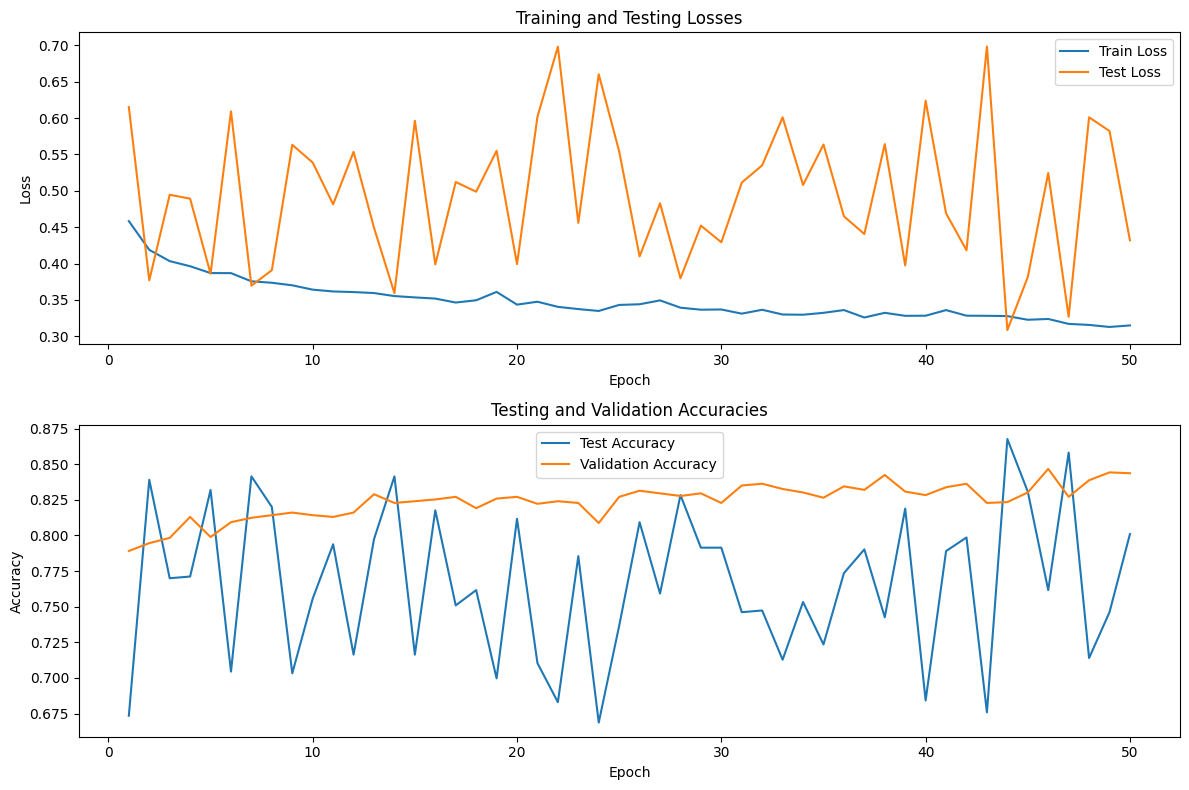

In [24]:
process_model(GAT)

Epoch 1: Train Loss 0.4462, Test Loss 0.3808, Test Accuracy 0.8379, Val Accuracy 0.7842
Epoch 2: Train Loss 0.4068, Test Loss 0.7052, Test Accuracy 0.6031, Val Accuracy 0.7952
Epoch 3: Train Loss 0.3889, Test Loss 0.3876, Test Accuracy 0.8367, Val Accuracy 0.8032
Epoch 4: Train Loss 0.3839, Test Loss 0.4195, Test Accuracy 0.8105, Val Accuracy 0.8099
Epoch 5: Train Loss 0.3712, Test Loss 0.9599, Test Accuracy 0.5518, Val Accuracy 0.7915
Epoch 6: Train Loss 0.3645, Test Loss 0.4965, Test Accuracy 0.7688, Val Accuracy 0.8283
Epoch 7: Train Loss 0.3617, Test Loss 0.3488, Test Accuracy 0.8534, Val Accuracy 0.8142
Epoch 8: Train Loss 0.3549, Test Loss 0.4754, Test Accuracy 0.7807, Val Accuracy 0.8314
Epoch 9: Train Loss 0.3479, Test Loss 0.3719, Test Accuracy 0.8367, Val Accuracy 0.8277
Epoch 10: Train Loss 0.3430, Test Loss 0.5608, Test Accuracy 0.7402, Val Accuracy 0.8369
Epoch 11: Train Loss 0.3372, Test Loss 0.4618, Test Accuracy 0.7902, Val Accuracy 0.8412
Epoch 12: Train Loss 0.3328, T

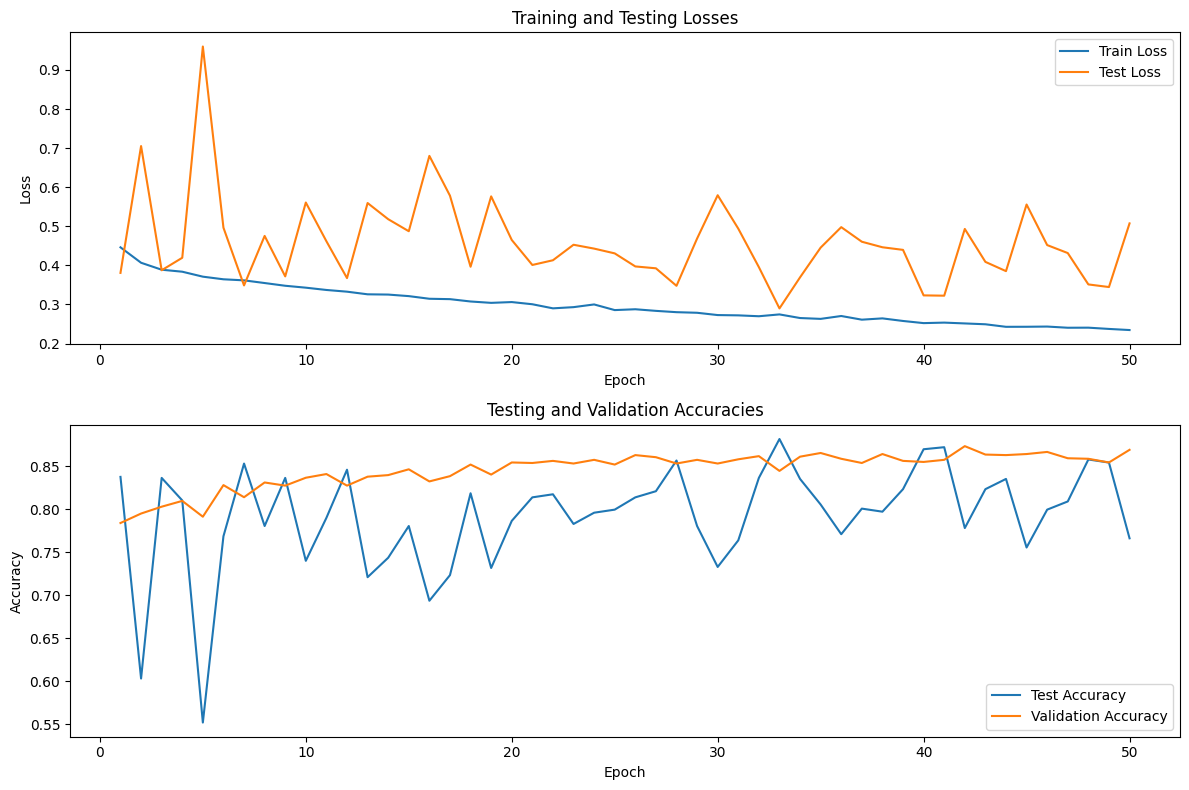

In [25]:
process_model(GraphSAGE)

Epoch 1: Train Loss 0.4240, Test Loss 0.5235, Test Accuracy 0.7247, Val Accuracy 0.8038
Epoch 2: Train Loss 0.3996, Test Loss 0.7133, Test Accuracy 0.5328, Val Accuracy 0.7689
Epoch 3: Train Loss 0.3859, Test Loss 0.5992, Test Accuracy 0.6663, Val Accuracy 0.8179
Epoch 4: Train Loss 0.3781, Test Loss 0.3427, Test Accuracy 0.8451, Val Accuracy 0.8314
Epoch 5: Train Loss 0.3700, Test Loss 0.2622, Test Accuracy 0.8951, Val Accuracy 0.7885
Epoch 6: Train Loss 0.3722, Test Loss 0.2628, Test Accuracy 0.8892, Val Accuracy 0.8240
Epoch 7: Train Loss 0.3589, Test Loss 0.4989, Test Accuracy 0.7735, Val Accuracy 0.8265
Epoch 8: Train Loss 0.3553, Test Loss 0.6087, Test Accuracy 0.6806, Val Accuracy 0.8063
Epoch 9: Train Loss 0.3457, Test Loss 0.5116, Test Accuracy 0.7664, Val Accuracy 0.8400
Epoch 10: Train Loss 0.3404, Test Loss 0.4983, Test Accuracy 0.7795, Val Accuracy 0.8320
Epoch 11: Train Loss 0.3440, Test Loss 0.3017, Test Accuracy 0.8892, Val Accuracy 0.7456
Epoch 12: Train Loss 0.3367, T

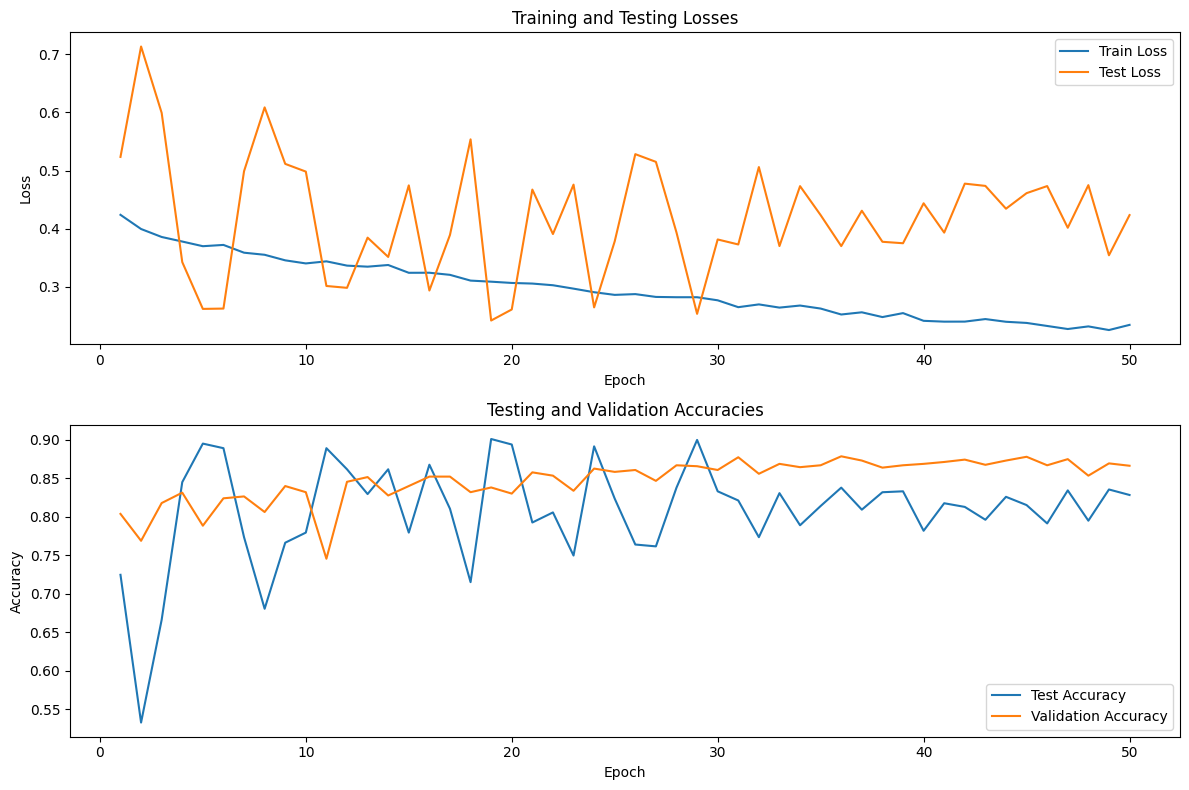

In [26]:
process_model(GIN)